In [113]:
import pandas as pd
from fairlearn.datasets import fetch_adult

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split

from src.classifiers.curriculum_classifier import CurriculumClassifier
from src.utils.learning_difficulty import group_by_difficulty

In [114]:
X, y = fetch_adult(return_X_y=True, as_frame=True)
sensitive_feature_names = ['sex', 'race']

sensitive_features = X[sensitive_feature_names]
X = X.drop(columns=sensitive_feature_names)

X.isna().sum()

age                  0
workclass         2799
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        2809
relationship         0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     857
dtype: int64

In [115]:
X['workclass'].fillna(X.mode()['workclass'][0], inplace=True)
X['occupation'].fillna(X.mode()['occupation'][0], inplace=True)
X['native-country'].fillna(X.mode()['native-country'][0], inplace=True)

C:\Users\Tine Šuster\AppData\Local\Temp\ipykernel_16080\3529112877.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X['workclass'].fillna(X.mode()['workclass'][0], inplace=True)
C:\Users\Tine Šuster\AppData\Local\Temp\ipykernel_16080\3529112877.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always be

In [116]:
# Encode categorical features
categorical_features = X.select_dtypes(include=['object', 'category']).columns
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ],
    remainder='passthrough'
)

X = preprocessor.fit_transform(X).toarray()

In [117]:
random_seed = 1234

X_train, X_test, y_train, y_test, sensitive_train, sensitive_test = train_test_split(
    X, y, sensitive_features, test_size=0.2, random_state=random_seed
)

curriculum_classifier = CurriculumClassifier(base_estimator=SGDClassifier(random_state=random_seed), method='entropy', n_groups=3)
curriculum_classifier.fit(X_train, y_train)

sgd_classifier = SGDClassifier(random_state=random_seed)
sgd_classifier.fit(X_train, y_train)

SGDClassifier(random_state=1234)

In [118]:
# Predictions
y_pred_curriculum = curriculum_classifier.predict(X_test)
y_pred_sgd = sgd_classifier.predict(X_test)


In [119]:
from sklearn.metrics import accuracy_score, recall_score, f1_score, explained_variance_score
y_pred_curriculum_accuracy = accuracy_score(y_test, y_pred_curriculum)
y_pred_curriculum_recall = recall_score(y_test, y_pred_curriculum, average='weighted')
y_pred_curriculum_f1 = f1_score(y_test, y_pred_curriculum, average='weighted')

y_pred_sgd_accuracy = accuracy_score(y_test, y_pred_sgd)
y_pred_sgd_recall = recall_score(y_test, y_pred_sgd, average='weighted')
y_pred_sgd_f1 = f1_score(y_test, y_pred_sgd, average='weighted')

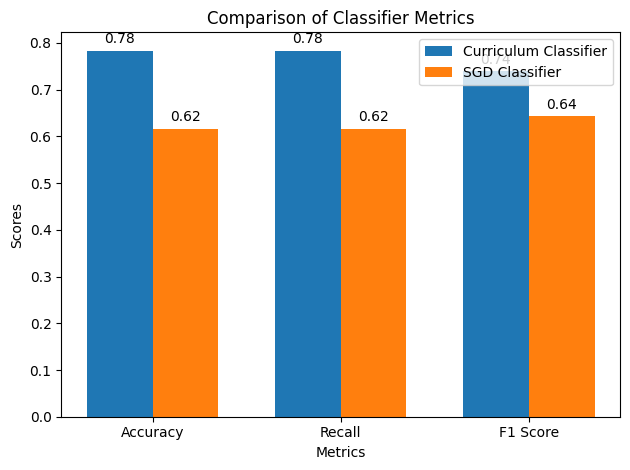

In [120]:
import matplotlib.pyplot as plt
import numpy as np

curriculum_metrics = [
    y_pred_curriculum_accuracy,
    y_pred_curriculum_recall,
    y_pred_curriculum_f1
]

sgd_metrics = [
    y_pred_sgd_accuracy,
    y_pred_sgd_recall,
    y_pred_sgd_f1
]

metric_names = ['Accuracy', 'Recall', 'F1 Score']

x = np.arange(len(metric_names))

width = 0.35
fig, ax = plt.subplots()
bars1 = ax.bar(x - width/2, curriculum_metrics, width, label='Curriculum Classifier')
bars2 = ax.bar(x + width/2, sgd_metrics, width, label='SGD Classifier')

ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Comparison of Classifier Metrics')
ax.set_xticks(x)
ax.set_xticklabels(metric_names)
ax.legend()

def autolabel(bars):
    """Attach a text label above each bar in *bars*, displaying its height."""
    for bar in bars:
        height = bar.get_height()
        ax.annotate('{}'.format(round(height, 2)),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(bars1)
autolabel(bars2)

fig.tight_layout()

plt.show()